# Tarea: Highway 
## Redes Neuronales 

---

03 de noviembre de 2016

In [3]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf

Datos

In [87]:
#dia = csv.excel()
df = pd.read_table("../datos_clase/carretera4.csv",sep = ",", header=None)

In [88]:
print df.shape
df.head()

(66, 6)


,0,1,2,3,4,5
0,1,0,0,0,0,1
1,1,1,1,0,0,1
2,1,0,0,0,1,1
3,1,1,0,1,0,1
4,1,0,0,0,0,1


Simulador carretera

In [89]:
class HighwaySimulator:
	"""This class keeps track of the state of the world and is able to sense it"""
	MAXCRASHES=1000
	def __init__(self,world,grafica=True):
		self.world=world
		self.positionY=0
		self.positionX=random.randint(1,len(world.columns)-2)
		self.trayectoriaX=[self.positionX]
		self.trayectoriaY=[self.positionY]
		self.crashes=0
		self.steps=0
		self.out=False
		self.graficar=grafica
		#graficar
		if grafica:
			l=[(j,world.ix[i,j]*i) for i in range(len(world.index)) for j in range(len(world.columns)) ]
			l=zip(*l)
			plt.scatter(l[0],l[1])
		
	#returns the values (for now noiseless of the Moore neighborhood) from left to right, top to bottom 
	def sensor(self):
		output=[]
		positionY=self.positionY
		positionX=self.positionX
		world=self.world
		if positionY==0:
			output= output + [1,1,1] #behind limit
		else:
			output=output + [df.ix[positionY-1,positionX-1],df.ix[positionY-1,positionX],df.ix[positionY-1,positionX+1] ] #behind
		output=output + [df.ix[positionY,positionX-1],df.ix[positionY,positionX],df.ix[positionY,positionX+1] ] #sides
		if positionY==len(world.index)-1: #front boundary
			output= output + [1,1,1]
		else:
			output=output + [df.ix[positionY+1,positionX-1],df.ix[positionY+1,positionX],df.ix[positionY+1,positionX+1] ] #front
		return output
		
	###Set an arbitrary position
	def setPosition(self,x,y):
		world=self.world
		if x<=1:
			self.positionX=1
		else:
			if x >= len(world.columns) -2:
				self.positionX=len(world.columns) -2
			else:
				self.positionX=x
		
		if y<=0:
			self.positionY=0
		else:
			if y >= len(world.index) -1:
				self.positionY=len(world.index) -1
			else:
				self.positionY=y
	
	def checkPosition(self,x,y):
		world=self.world
		if x<1:
			return 0
		
		if x > len(world.columns) -2:
			return 0
				
		if y<0:
			return 1
		
		if y >= len(world.index) -1:
			return 2
		if world.ix[y,x]==0:
			return 3
		else:
			return 0
	###Move
	def move(self,m):
		if self.out:
			print "You are already out"
			return
		if self.crashes >= self.MAXCRASHES:
			print "Too many accidents!!!!"
			return
		if m=='F':
			res=self.checkPosition(self.positionX,self.positionY+1)
			if res==3:
				self.positionY=self.positionY+1
			elif res==2:
				print 'You are out, congratulations!!'
				self.out=True
			else:
				print "Crash"
				self.crashes=self.crashes+1
		if m=='B':
			res=self.checkPosition(self.positionX,self.positionY-1)
			if res==3:
				self.positionY=self.positionY-1
			else:
				print "Crash"
				self.crashes=self.crashes+1
		if m=='R':
			res=self.checkPosition(self.positionX+1,self.positionY)
			if res==3:
				self.positionX=self.positionX+1
			else:
				print "Crash"
				self.crashes=self.crashes+1
		if m=='L':
			res=self.checkPosition(self.positionX-1,self.positionY)
			if res==3:
				self.positionX=self.positionX-1
			else:
				print "Crash"
				self.crashes=self.crashes+1	
		if res ==3 and self.graficar:
			self.trayectoriaX=self.trayectoriaX+[self.positionX]
			self.trayectoriaY=self.trayectoriaY+[self.positionY]
			plt.plot(self.trayectoriaX,self.trayectoriaY,color='red')
		
		self.steps=self.steps+1	


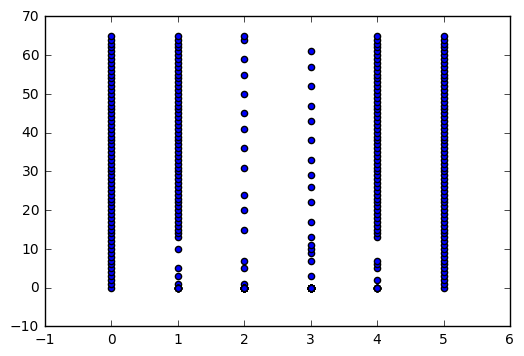

In [90]:
 carre=HighwaySimulator(df)

[1, 1, 1, 0, 0, 1, 0, 0, 1]
[0, 0, 1, 0, 0, 1, 0, 1, 1]


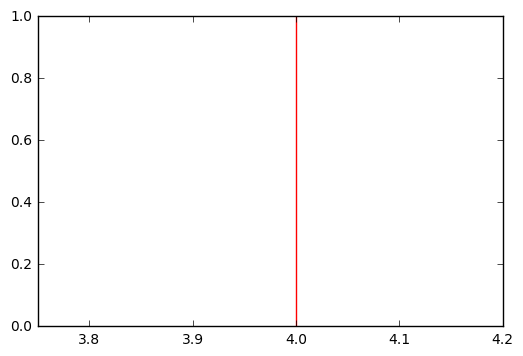

In [91]:
print carre.sensor()
carre.move('F')
print carre.sensor()

Preparación de Datos para entrenamiento

In [92]:
# Input de red
def per(n):
    vec =[]
    for i in range(1<<n):
        s=bin(i)[2:]
        s='0'*(n-len(s))+s
        aux = map(int,list(s))
        #aux2 = np.concatenate(aux[0:3], 0, aux[6:9])
        aux2 = aux[0:6] + [0]+ aux[6:10]
        vec.append(aux2)
        #print map(int,list(s))
    return vec
ss = per(8)
ss[:5]

[[0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 1],
 [0, 0, 0, 0, 0, 0, 0, 1, 0],
 [0, 0, 0, 0, 0, 0, 0, 1, 1],
 [0, 0, 0, 0, 0, 1, 0, 0, 0]]

In [93]:
# Salida por permutacion
def ys(sens):
    if sens[7]==0:
        # posiciones: F, B, L, R
        y = [1,0,0,0]
        return y
    elif sens[3]+sens[5] == 0:
        if random.choice([True,False]):
            y = [0,0,1,0]
            return y
        else:
            y = [0,0,0,1]
            return y
    elif sens[3] == 0:
        y = [0,0,1,0]
        return y
    elif sens[5] ==0:
        y = [0,0,0,1]
        return y
    elif sens[1]==0:
        y = [0,1,0,0]
        return y

In [94]:
# Excluir casos sin salida
yt = [ys(x) for x in ss]
buenos = [x for x in range(len(yt)) if yt[x] != None]
yt = [yt[x] for x in buenos]
xt = [ss[x] for x in buenos]

In [95]:
# · Definición de Red
input_size = 9
hdn_layer = 9
output_layer = 4

# Definición de layers
x = tf.placeholder(tf.float32, [None, input_size])
y_ = tf.placeholder(tf.float32, [None, output_layer]) # la y real

W_layer1 = tf.Variable(tf.random_uniform([input_size, hdn_layer], -1, 1), 
                       name = "W_layer1")
b_layer1 = tf.Variable(tf.zeros([hdn_layer]), 
                       name = "b_layer1")

W_layer2 = tf.Variable(tf.random_uniform([hdn_layer, output_layer], -1, 1), 
                       name = "W_layer2")
b_layer2 = tf.Variable(tf.zeros([output_layer]), 
                       name = "b_layer2")

# Modelo
hdn = tf.nn.sigmoid( tf.matmul(x,W_layer1) + b_layer1)
y = tf.nn.sigmoid( tf.matmul(hdn,W_layer2) + b_layer2) 

# Función de pérdida 
# cuadrática
#lossfn = tf.reduce_mean( tf.reduce_sum((y_ - y)**2) )
# entropía
lossfn= tf.reduce_mean(( (y_ * tf.log(y)) +  
                        ((1 - y_) * tf.log(1.0 - y)) ) * -1) 

# Algoritmo de entrenamiento
train_step = tf.train.GradientDescentOptimizer(.01).minimize(lossfn)

In [96]:
# Entrenamiento de red
init = tf.initialize_all_variables()
sess = tf.Session() # tipo de sesion, puede ser interactiva
sess.run(init)
for i in range(30000):
  sess.run(train_step, feed_dict={x: xt, y_: yt})

In [97]:
# Accuracy
correct_prediction = tf.equal(tf.round(y),y_) # aca estams definiendo otras operacioes
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
print(sess.run(accuracy, feed_dict={x: xt, y_: yt})) # las corremos

0.945833


In [98]:
# Predicción 
# F,B,L,R
output_guess = sess.run(y, feed_dict={x: xt, y_: yt})
print( yt[200:203] )
print( output_guess[200:203] )

[[1, 0, 0, 0], [1, 0, 0, 0], [0, 0, 0, 1]]
[[ 0.95306355  0.01625905  0.01413293  0.03858689]
 [ 0.95445383  0.01643498  0.01155653  0.04246777]
 [ 0.02793551  0.12408105  0.22981644  0.56006438]]


In [99]:
# Función de posición: "F", "B", "L", "R"
def NextStep(listin):
    goto = ""
    if listin == [1, 0, 0, 0] or listin == 0:
        goto = "F"
    elif listin == [0, 1, 0, 0] or listin == 1:
        goto = "B"
    elif listin == [0, 0, 1, 0] or listin == 2:
        goto = "L"
    elif listin == [0, 0, 0, 1] or listin == 3:
        goto = "R"
    else:
        goto = "weird!"
    return goto

# Función de Lista
def GetPosVec(numin):
    outout = ""
    if numin == 0:
        outout = [1, 0, 0, 0]
    elif numin == 1:
        outout = [0, 1, 0, 0]
    elif numin == 2:
        outout = [0, 0, 1, 0]
    elif numin == 3:
        outout = [0, 0, 0, 1]
    else:
        outout = "weird!"
    return outout

Avance en Simulador dado red

el número de crashes fue:  0


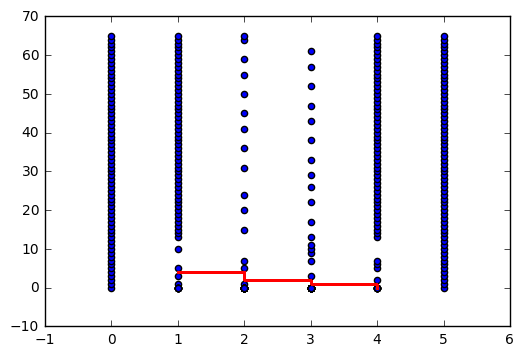

In [100]:
carre = HighwaySimulator(df)
cuentav = 0
cuentamoves = 0
while cuentav < 67 and cuentamoves < 1000: # el número de renglones que tenga la red
    x1 = carre.sensor()
    # predicción de la red dado posición
    predprobs = sess.run(y, feed_dict={x: [x1], y_: [ys(x1)]})
    # lista según prob máxima
    listmove = GetPosVec(predprobs[0].argmax())
    # siguiente movimiento
    nextmove = NextStep(listmove)
    # ojo con cuenta si va de reversa
    if nextmove == "F":
        cuentav = cuentav + 1
    elif nextmove == "B":
        cuentav = cuentav - 1
    carre.move(nextmove)
    cuentamoves = cuentamoves + 1
print "el número de crashes fue: ", carre.crashes

In [101]:
print cuentav
print cuentamoves
print carre.positionX
print carre.positionY

4
1000
2
4


[1, 1, 1, 0, 0, 0, 1, 1, 0]


2

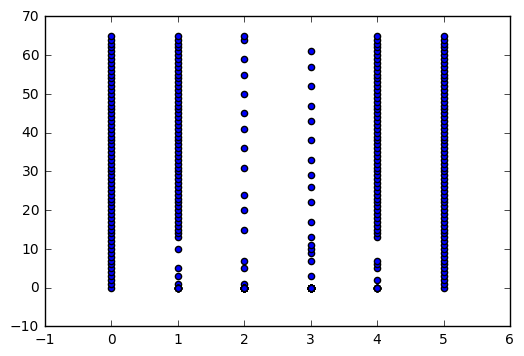

In [102]:
carre = HighwaySimulator(df)
print carre.sensor()
carre.positionX